In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dipole

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield, lf3d, j3d
from mhsflex.vis import plot
from mhsflex.metrics import compare_field3d
import scipy
from matplotlib import rc, colors
import matplotlib.pyplot as plt

from mhsflex.poloidal import (
    phi,
    phi_low,
    phi_hypgeo,
    dphidz_hypgeo,
    dphidz,
    dphidz_low,
)

from mhsflex.b3d import b3d

from mhsflex.fluxbalance import b3d_fb

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)
c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

In [11]:
nresol_x = 400
nresol_y = nresol_x
nresol_z = 400
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = nresol_x

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [3]:
a = 0.22
alpha = 0.05
b = 1.0
z0 = 2.0
deltaz = 0.2

In [13]:
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * data2d.px
length_scale_y = 2.0 * nresol_y * data2d.py

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

In [6]:
phi_asymp = np.zeros((nf_max, nf_max, nresol_z))
dphidz_asymp = np.zeros((nf_max, nf_max, nresol_z))
phi_hyper = np.zeros((nf_max, nf_max, nresol_z))
dphidz_hyper = np.zeros((nf_max, nf_max, nresol_z))

In [7]:
deltaz = 0.2

p_arr = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2)
)
q_arr = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
)

In [8]:
def check_runtime_pa():
    for iz, z in enumerate(z_arr):
        phi_asymp[:, :, iz] = phi(z, p_arr, q_arr, z0, deltaz)

In [ ]:
%timeit -n 100 -r 10 check_runtime_pa()

In [12]:
def check_runtime_ph():
    for iz, z in enumerate(z_arr):
        phi_hyper[:, :, iz] = phi_hypgeo(z, p_arr, q_arr, z0, deltaz)

In [ ]:
%timeit -n 100 -r 10 check_runtime_ph()

In [10]:
def check_runtime_dpa():
    for iz, z in enumerate(z_arr):
        dphidz_asymp[:, :, iz] = dphidz(z, p_arr, q_arr, z0, deltaz)

In [ ]:
%timeit -n 100 -r 10 check_runtime_dpa()

In [11]:
def check_runtime_dph():
    for iz, z in enumerate(z_arr):
        dphidz_hyper[:, :, iz] = dphidz_hypgeo(z, p_arr, q_arr, z0, deltaz)

In [ ]:
%timeit -n 100 -r 10 check_runtime_dph()

In [4]:
def check_runtime_b_asymptotic_seehafer():
    b3d(data2d, a, b, alpha, z0, deltaz, asymptotic=True, tanh=True)

In [5]:
def check_runtime_b_asymptotic_balanced():
    b3d_fb(data2d, a, b, alpha, z0, deltaz, asymptotic=True, tanh=True)

In [6]:
def check_runtime_b_nw_seehafer():
    b3d(data2d, a, b, alpha, z0, deltaz, asymptotic=False, tanh=True)

In [7]:
def check_runtime_b_nw_balanced():
    b3d_fb(data2d, a, b, alpha, z0, deltaz, asymptotic=False, tanh=True)

In [8]:
nresol_x = 2048
nresol_y = nresol_x
nresol_z = 200
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = nresol_x

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [9]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_seehafer()

310 ms ± 32.5 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [10]:
%timeit -n 5 -r 5 check_runtime_b_nw_seehafer()

694 ms ± 136 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [11]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_balanced()

66.9 ms ± 9.13 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [12]:
%timeit -n 5 -r 5 check_runtime_b_nw_balanced()

144 ms ± 141 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [8]:
nresol_x = 300
nresol_y = nresol_x
nresol_z = 200
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = nresol_x

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [9]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_seehafer()

17.8 s ± 1.15 s per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [10]:
%timeit -n 5 -r 5 check_runtime_b_nw_seehafer()

29.2 s ± 962 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [11]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_balanced()

9.67 s ± 720 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [12]:
%timeit -n 5 -r 5 check_runtime_b_nw_balanced()

10.2 s ± 797 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [13]:
nresol_x = 350
nresol_y = nresol_x
nresol_z = 200
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = nresol_x

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [14]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_seehafer()

22.6 s ± 1.02 s per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [15]:
%timeit -n 5 -r 5 check_runtime_b_nw_seehafer()

36 s ± 500 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [16]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_balanced()

10.9 s ± 375 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [17]:
%timeit -n 5 -r 5 check_runtime_b_nw_balanced()

14.4 s ± 350 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [18]:
nresol_x = 550
nresol_y = nresol_x
nresol_z = 200
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = nresol_x

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [19]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_seehafer()

KeyboardInterrupt: 

In [25]:
%timeit -n 5 -r 5 check_runtime_b_nw_seehafer()

10.6 s ± 524 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [26]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_balanced()

2.7 s ± 207 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [27]:
%timeit -n 5 -r 5 check_runtime_b_nw_balanced()

3.73 s ± 230 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [28]:
nresol_x = 600
nresol_y = nresol_x
nresol_z = 200
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = nresol_x

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [29]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_seehafer()

9.97 s ± 159 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [30]:
%timeit -n 5 -r 5 check_runtime_b_nw_seehafer()

16.9 s ± 133 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [31]:
%timeit -n 5 -r 5 check_runtime_b_asymptotic_balanced()

4.51 s ± 237 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [32]:
%timeit -n 5 -r 5 check_runtime_b_nw_balanced()

6.31 s ± 216 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [115]:
resolution = np.array((50, 100, 150, 200, 250, 300, 350, 400, 450, 500)) ** 2 * 200

In [116]:
asymp_see = np.array((0.31, 1.1, 3.02, 5.6, 9.97, 17.8, 22.6, 30.9, 41.3, 78.0))

In [117]:
e1, d1, a1, b1 = np.polyfit(resolution, asymp_see, 3)

In [118]:
f1 = scipy.interpolate.interp1d(resolution, asymp_see)
xnew = np.arange(50**2 * 200, 500**2 * 200, 10)
ynew1 = f1(xnew)

In [119]:
hyp_see = np.array((0.694, 2.15, 5.81, 10.6, 16.9, 29.2, 36.0, 49.9, 69.0, 163.0))

In [120]:
e2, d2, a2, b2 = np.polyfit(resolution, hyp_see, 3)

In [121]:
f2 = scipy.interpolate.interp1d(resolution, hyp_see)
ynew2 = f2(xnew)

In [122]:
asymp_fb = np.array((0.067, 0.637, 1.67, 2.7, 4.51, 9.67, 10.9, 13.4, 25.7, 29.3))

In [123]:
e3, d3, a3, b3 = np.polyfit(resolution, asymp_fb, 3)

In [124]:
f3 = scipy.interpolate.interp1d(resolution, asymp_fb)
ynew3 = f3(xnew)

In [125]:
hyp_fb = np.array((0.144, 0.988, 1.97, 3.73, 6.31, 10.2, 14.4, 20.8, 29.3, 36.5))

In [126]:
e4, d4, a4, b4 = np.polyfit(resolution, hyp_fb, 3)

In [127]:
f4 = scipy.interpolate.interp1d(resolution, hyp_fb)
ynew4 = f4(xnew)

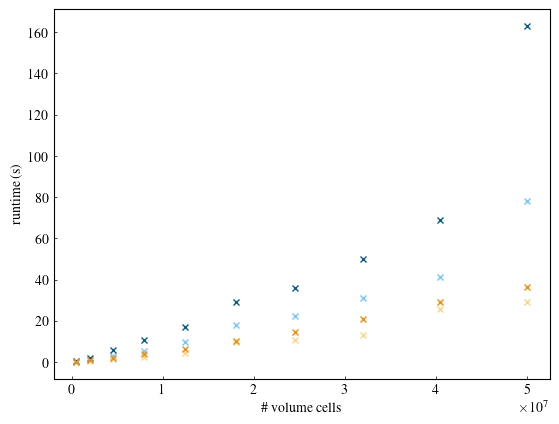

In [138]:
fig, ax1 = plt.subplots()

ax1.plot(
    resolution,
    asymp_see,
    "x",
    markersize=4,
    linewidth=0.4,
    color=c1,
)
# ax1.plot(
#     resolution,
#     e1 * resolution**3 + d1 * resolution**2 + a1 * resolution + b1,
#     linewidth=0.4,
#     color=c1,
# )
# ax1.plot(
#     xnew,
#     ynew1,
#     linewidth=0.4,
#     color=c1,
# )
ax1.plot(
    resolution,
    hyp_see,
    "x",
    markersize=4,
    linewidth=0.4,
    color=(0.000, 0.365, 0.580),
)
# ax1.plot(
#     resolution,
#     e2 * resolution**3 + d2 * resolution**2 + a2 * resolution + b2,
#     linewidth=0.4,
#     color=(0.000, 0.365, 0.580),
# )
# ax1.plot(
#     xnew,
#     ynew2,
#     linewidth=0.4,
#     color=(0.000, 0.365, 0.580),
# )
ax1.plot(
    resolution,
    asymp_fb,
    "x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.831, 0.514),
)
# ax1.plot(
#     resolution,
#     e3 * resolution**3 + d3 * resolution**2 + a3 * resolution + b3,
#     linewidth=0.4,
#     color=(1.000, 0.831, 0.514),
# )
# ax1.plot(
#     xnew,
#     ynew3,
#     linewidth=0.4,
#     color=(1.000, 0.831, 0.514),
# )
ax1.plot(
    resolution,
    hyp_fb,
    "x",
    markersize=4,
    linewidth=0.4,
    color=(1.000, 0.537, 0.000),
)
# ax1.plot(
#     resolution,
#     e4 * resolution**3 + d4 * resolution**2 + a4 * resolution + b4,
#     linewidth=0.4,
#     color=(1.000, 0.537, 0.000),
# )
# ax1.plot(
#     xnew,
#     ynew4,
#     linewidth=0.4,
#     color=(1.000, 0.537, 0.000),
# )
ax1.tick_params(direction="in", length=2, width=0.5)
ax1.set_xlabel(r"\# volume cells")
ax1.set_ylabel(r"runtime (s)")
# ax1.set_yscale("log")
# ax1.set_xscale("log")
plotname = "/Users/lilli/Desktop/runtime.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()